# Test model output

The following notebook contains tests of the output generated by model.
The tests check the legality of predicted moves and the correctness of predicted game result.

The tests are performed for model trained on simple tokenization (11 tokens)

In [1]:
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from model import GPTConfig, GPT
from c4engine import C4Engine

In [2]:
OUT_DIR = 'out-connect-four-simple'
DEVICE = 'cuda'

In [3]:
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = torch.amp.autocast(device_type=DEVICE, dtype=ptdtype)

Load model

In [4]:
# init from a model saved in a specific directory
ckpt_path = os.path.join(OUT_DIR, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=DEVICE)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)
state_dict = checkpoint['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to(DEVICE)
# model = torch.compile(model)

number of parameters: 10.63M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 384)
    (wpe): Embedding(44, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=11, bias=False)
)

Load dataset

In [5]:
# read metadata
data_dir = os.path.join('data', checkpoint['config']['dataset'])
meta_path = os.path.join(data_dir, 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

# get encode/decode - tokenizer
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

eos_token_ids = meta['eos_token_ids']

# read dataset
block_size = meta['block_size']
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r').reshape(-1, block_size+1)

## Legal move and game result prediction

In [12]:
def test_legal_move_and_game_result_prediction(data):
    strings = set()
    correct_legal, total_legal = 0, 0
    correct_result, total_result = 0, 0

    for seq in data:
        engine = C4Engine()
        seq_str = decode(seq)
        for i in range(len(seq)):
            engine.make_move(seq_str[i])

            if seq_str[:i+1] in strings:
                continue
            strings.add(seq_str[:i+1])

            # predict next token (move or game result)
            x = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
            y = model.generate(idx=x, max_new_tokens=1, top_k=1)
            predicted = decode(y[0].tolist())[-1]

            # if game finished check predicted result
            if engine.result() is not None:
                if predicted == engine.result():
                    correct_result += 1
                total_result += 1
                break

            # check if predicted move is legal
            if engine.is_legal_move(predicted):
                correct_legal += 1
            total_legal += 1

    return correct_legal, total_legal, correct_result, total_result

In [13]:
correct_legal_val, total_legal_val, correct_result_val, total_result_val = test_legal_move_and_game_result_prediction(val_data)

In [14]:
print(f"Legal moves predicted (validation data): {correct_legal_val}/{total_legal_val} ({100.0*correct_legal_val/total_legal_val:.2f}%)")
print(f"Game result predicted (validation data): {correct_result_val}/{total_result_val} ({100.0*correct_result_val/total_result_val:.2f}%)")

Legal moves predicted (validation data): 59133/59665 (99.11%)
Game result predicted (validation data): 1610/2000 (80.50%)


In [15]:
correct_legal_train, total_legal_train, correct_result_train, total_result_train = test_legal_move_and_game_result_prediction(train_data)

In [16]:
print(f"Legal moves predicted (training data): {correct_legal_train}/{total_legal_train} ({100.0*correct_legal_train/total_legal_train:.2f}%)")
print(f"Game result predicted (training data): {correct_result_train}/{total_result_train} ({100.0*correct_result_train/total_result_train:.2f}%)")

Legal moves predicted (training data): 494216/498639 (99.11%)
Game result predicted (training data): 15101/18000 (83.89%)


## Probing

### Get output from hidden layers of the model

In [6]:
activations = {}

def get_hook(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks on each block
for i, block in enumerate(model.transformer.h):
    block.register_forward_hook(get_hook(f'block_{i}'))

### Prepare dataset

In [7]:
field_to_int = {C4Engine.EMPTY: 0, C4Engine.PLAYERS[0]: 1, C4Engine.PLAYERS[1]: 2}

def get_probe_dataset(data):
    strings = set()
    X = []
    Y_cell = []
    Y_col = []
    Y_row = []

    for seq in data:
        i = np.random.randint(1, len(seq))
        seq_str = decode(seq[:i])
        # seq_str = decode(seq)
        # engine = C4Engine()
        # for i in range(len(seq)):
        # engine.make_move(seq_str[i])
        engine = C4Engine(seq_str)

        # if seq_str[:i+1] in strings:
        #     continue
        # strings.add(seq_str[:i+1])
        if seq_str in strings:
            continue
        strings.add(seq_str)

        board = engine.board()

        inp = (torch.tensor(seq[:i], dtype=torch.long, device=DEVICE)[None, ...])
        # inp = (torch.tensor(seq[:i+1], dtype=torch.long, device=DEVICE)[None, ...])
        _, _ = model(inp)
        X.append(activations['block_5'][:, -1, :].reshape(-1).cpu())
        Y_cell.append(torch.tensor([field_to_int[f] for row in board for f in row]))
        Y_col.append(torch.tensor([sum(1 for i in range(6) if board[i][j] in C4Engine.PLAYERS) for j in range(7)]))
        Y_row.append(torch.tensor([sum(1 for c in row if c in C4Engine.PLAYERS) for row in board]))

        # if engine.result() is not None:
        #     break

    X = torch.stack(X)
    Y_cell = torch.stack(Y_cell)
    Y_col = torch.stack(Y_col)
    Y_row = torch.stack(Y_row)

    return X, Y_cell, Y_col, Y_row

In [8]:
train_X, train_Y_cell, train_Y_col, train_Y_row = get_probe_dataset(train_data)

In [9]:
train_X.shape, train_Y_cell.shape, train_Y_col.shape, train_Y_row.shape

(torch.Size([16343, 384]),
 torch.Size([16343, 42]),
 torch.Size([16343, 7]),
 torch.Size([16343, 6]))

In [10]:
val_X, val_Y_cell, val_Y_col, val_Y_row = get_probe_dataset(val_data)

In [11]:
val_X.shape, val_Y_cell.shape, val_Y_col.shape, val_Y_row.shape

(torch.Size([1885, 384]),
 torch.Size([1885, 42]),
 torch.Size([1885, 7]),
 torch.Size([1885, 6]))

### Train linear probes

In [39]:
class LinearBoardProbe(nn.Module):
    def __init__(self, dim_x, dim_y, num_cls):
        super().__init__()
        # 42 cells × 3 classes
        self._dim_x = dim_x
        self._dim_y = dim_y
        self._num_cls = num_cls
        self.linear = nn.Linear(dim_x, dim_y * num_cls, device=DEVICE)

    def forward(self, x):
        # x: (B,384)
        out = self.linear(x)
        return out.view(-1, self._dim_y, self._num_cls)

In [40]:
def get_data_loader(X, Y, batch_size=1024):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True)

In [41]:
def train_probe(X, Y, num_cls):
    probe = LinearBoardProbe(dim_x=X.shape[-1], dim_y=Y.shape[-1], num_cls=num_cls).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        probe.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    epochs = 1024
    batch_size = 1024

    train_loader = get_data_loader(X, Y, batch_size)

    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)

            loss = criterion(
                preds.view(-1, probe._num_cls),
                y.view(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch:3d}: {total_loss/len(train_loader):.4f}')

    return probe, train_loader

Predict value of each cell

In [42]:
cell_probe, cell_train_loader = train_probe(train_X, train_Y_cell, num_cls=3)

Epoch   0: 3.0137
Epoch   1: 1.4686
Epoch   2: 1.0492
Epoch   3: 0.8433
Epoch   4: 0.7337
Epoch   5: 0.6681
Epoch   6: 0.6268
Epoch   7: 0.5974
Epoch   8: 0.5753
Epoch   9: 0.5583
Epoch  10: 0.5448
Epoch  11: 0.5338
Epoch  12: 0.5243
Epoch  13: 0.5166
Epoch  14: 0.5100
Epoch  15: 0.5036
Epoch  16: 0.4983
Epoch  17: 0.4936
Epoch  18: 0.4894
Epoch  19: 0.4856
Epoch  20: 0.4817
Epoch  21: 0.4785
Epoch  22: 0.4751
Epoch  23: 0.4721
Epoch  24: 0.4695
Epoch  25: 0.4673
Epoch  26: 0.4652
Epoch  27: 0.4631
Epoch  28: 0.4613
Epoch  29: 0.4589
Epoch  30: 0.4571
Epoch  31: 0.4553
Epoch  32: 0.4542
Epoch  33: 0.4523
Epoch  34: 0.4509
Epoch  35: 0.4493
Epoch  36: 0.4479
Epoch  37: 0.4466
Epoch  38: 0.4455
Epoch  39: 0.4441
Epoch  40: 0.4430
Epoch  41: 0.4423
Epoch  42: 0.4406
Epoch  43: 0.4400
Epoch  44: 0.4389
Epoch  45: 0.4376
Epoch  46: 0.4366
Epoch  47: 0.4358
Epoch  48: 0.4347
Epoch  49: 0.4342
Epoch  50: 0.4335
Epoch  51: 0.4327
Epoch  52: 0.4315
Epoch  53: 0.4307
Epoch  54: 0.4299
Epoch  55:

Predict number of pieces in each column

In [55]:
col_probe, col_train_loader = train_probe(train_X, train_Y_col, num_cls=7)

Epoch   0: 5.5629
Epoch   1: 2.6675
Epoch   2: 1.8479
Epoch   3: 1.4687
Epoch   4: 1.2558
Epoch   5: 1.1237
Epoch   6: 1.0319
Epoch   7: 0.9619
Epoch   8: 0.9091
Epoch   9: 0.8663
Epoch  10: 0.8306
Epoch  11: 0.8011
Epoch  12: 0.7759
Epoch  13: 0.7547
Epoch  14: 0.7341
Epoch  15: 0.7166
Epoch  16: 0.7004
Epoch  17: 0.6868
Epoch  18: 0.6743
Epoch  19: 0.6605
Epoch  20: 0.6498
Epoch  21: 0.6390
Epoch  22: 0.6290
Epoch  23: 0.6198
Epoch  24: 0.6111
Epoch  25: 0.6022
Epoch  26: 0.5953
Epoch  27: 0.5877
Epoch  28: 0.5818
Epoch  29: 0.5748
Epoch  30: 0.5687
Epoch  31: 0.5624
Epoch  32: 0.5559
Epoch  33: 0.5504
Epoch  34: 0.5458
Epoch  35: 0.5405
Epoch  36: 0.5352
Epoch  37: 0.5313
Epoch  38: 0.5254
Epoch  39: 0.5207
Epoch  40: 0.5177
Epoch  41: 0.5130
Epoch  42: 0.5094
Epoch  43: 0.5054
Epoch  44: 0.5025
Epoch  45: 0.4978
Epoch  46: 0.4944
Epoch  47: 0.4913
Epoch  48: 0.4886
Epoch  49: 0.4855
Epoch  50: 0.4812
Epoch  51: 0.4777
Epoch  52: 0.4753
Epoch  53: 0.4718
Epoch  54: 0.4685
Epoch  55:

Predict number of pieces in each row

In [56]:
row_probe, row_train_loader = train_probe(train_X, train_Y_row, num_cls=8)

Epoch   0: 5.6986
Epoch   1: 2.7846
Epoch   2: 1.9421
Epoch   3: 1.5592
Epoch   4: 1.3537
Epoch   5: 1.2252
Epoch   6: 1.1386
Epoch   7: 1.0755
Epoch   8: 1.0272
Epoch   9: 0.9895
Epoch  10: 0.9599
Epoch  11: 0.9338
Epoch  12: 0.9117
Epoch  13: 0.8953
Epoch  14: 0.8786
Epoch  15: 0.8632
Epoch  16: 0.8503
Epoch  17: 0.8384
Epoch  18: 0.8274
Epoch  19: 0.8174
Epoch  20: 0.8090
Epoch  21: 0.8008
Epoch  22: 0.7938
Epoch  23: 0.7878
Epoch  24: 0.7813
Epoch  25: 0.7741
Epoch  26: 0.7675
Epoch  27: 0.7611
Epoch  28: 0.7568
Epoch  29: 0.7520
Epoch  30: 0.7470
Epoch  31: 0.7438
Epoch  32: 0.7390
Epoch  33: 0.7343
Epoch  34: 0.7295
Epoch  35: 0.7255
Epoch  36: 0.7225
Epoch  37: 0.7188
Epoch  38: 0.7160
Epoch  39: 0.7137
Epoch  40: 0.7091
Epoch  41: 0.7072
Epoch  42: 0.7051
Epoch  43: 0.7015
Epoch  44: 0.6984
Epoch  45: 0.6946
Epoch  46: 0.6929
Epoch  47: 0.6911
Epoch  48: 0.6881
Epoch  49: 0.6885
Epoch  50: 0.6853
Epoch  51: 0.6828
Epoch  52: 0.6800
Epoch  53: 0.6786
Epoch  54: 0.6768
Epoch  55:

### Test linear probes

In [43]:
def eval_probe(probe, loader, dim):
    correct = torch.zeros(dim, device=DEVICE)
    total = torch.zeros(dim, device=DEVICE)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = probe(x)
            pred_cls = preds.argmax(dim=-1)
            matches = (pred_cls == y).float()

            correct += matches.sum(dim=0)
            total += torch.ones_like(matches).sum(dim=0)

    return correct / total

In [73]:
def plot_heatmap(acc, w, h, title, xlabel, ylabel, disable_yticks=False, disable_xticks=False):
    board = acc.view(h, w).cpu()

    plt.figure()
    plt.imshow(board)
    plt.colorbar(label='Accuracy')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if disable_yticks:
        plt.yticks([])
    if disable_xticks:
        plt.xticks([])

    for i in range(h):
        for j in range(w):
            val = board[i, j].item()
            plt.text(
                j, i,
                f'{val:.2f}',
                ha='center',
                va='center'
            )

    plt.show()

Per cell

In [74]:
train_acc_cell = eval_probe(cell_probe, cell_train_loader, dim=train_Y_cell.shape[-1])
train_acc_cell

tensor([0.9296, 0.9027, 0.8992, 0.8955, 0.9279, 0.9569, 0.9805, 0.8574, 0.8349,
        0.8273, 0.8259, 0.8656, 0.9148, 0.9527, 0.7962, 0.7762, 0.7613, 0.7414,
        0.8001, 0.8484, 0.9151, 0.7654, 0.7427, 0.7343, 0.7280, 0.7656, 0.8157,
        0.8859, 0.7322, 0.7003, 0.6832, 0.6647, 0.7201, 0.7633, 0.8406, 0.6989,
        0.6719, 0.6687, 0.6880, 0.6785, 0.7004, 0.7784], device='cuda:0')

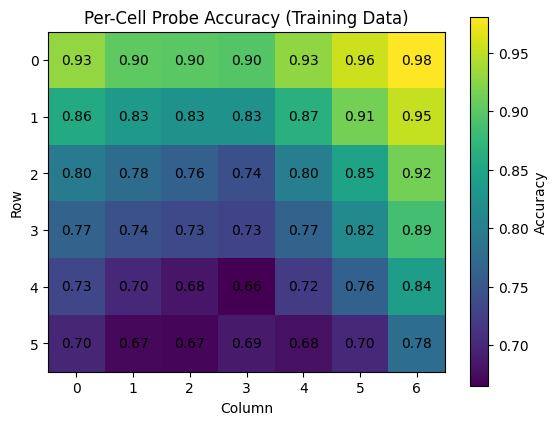

In [75]:
plot_heatmap(train_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Training Data)', xlabel='Column', ylabel='Row')

In [76]:
cell_val_loader = get_data_loader(val_X, val_Y_cell)
val_acc_cell = eval_probe(cell_probe, cell_val_loader, val_Y_cell.shape[-1])
val_acc_cell

tensor([0.9188, 0.8854, 0.8944, 0.8764, 0.9220, 0.9432, 0.9703, 0.8430, 0.8218,
        0.8133, 0.8095, 0.8451, 0.8992, 0.9432, 0.7714, 0.7427, 0.7496, 0.7114,
        0.7910, 0.8308, 0.9034, 0.7586, 0.7029, 0.7066, 0.7141, 0.7459, 0.7989,
        0.8732, 0.7225, 0.6870, 0.6642, 0.6446, 0.6939, 0.7485, 0.8403, 0.6775,
        0.6525, 0.6313, 0.6748, 0.6541, 0.6844, 0.7379], device='cuda:0')

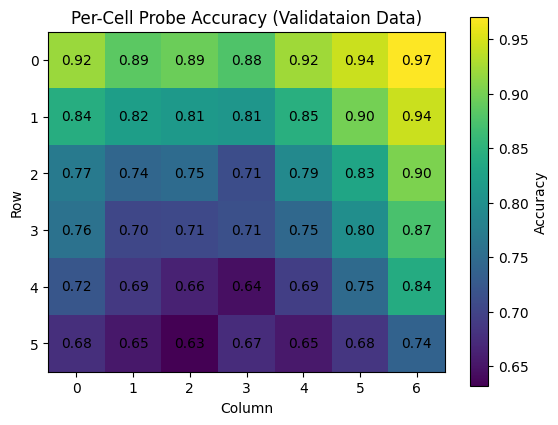

In [77]:
plot_heatmap(val_acc_cell, w=7, h=6, title=f'Per-Cell Probe Accuracy (Validataion Data)', xlabel='Column', ylabel='Row')

Per column

In [78]:
train_acc_col = eval_probe(col_probe, col_train_loader, dim=train_Y_col.shape[-1])
train_acc_col

tensor([0.9604, 0.9299, 0.9389, 0.9638, 0.9328, 0.9272, 0.9225],
       device='cuda:0')

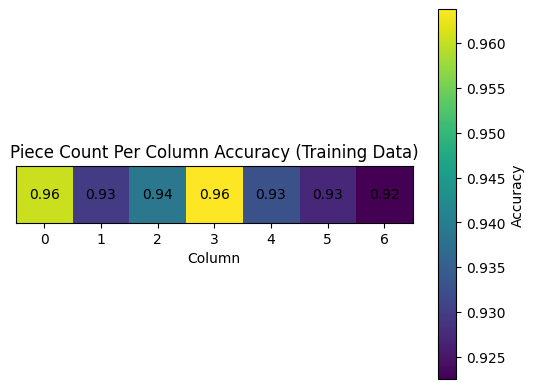

In [82]:
plot_heatmap(train_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Training Data)', xlabel='Column', ylabel='', disable_yticks=True)

In [83]:
col_val_loader = get_data_loader(val_X, val_Y_col)
val_acc_col = eval_probe(col_probe, col_val_loader, val_Y_col.shape[-1])
val_acc_col

tensor([0.9363, 0.9114, 0.9225, 0.9459, 0.9066, 0.8976, 0.9103],
       device='cuda:0')

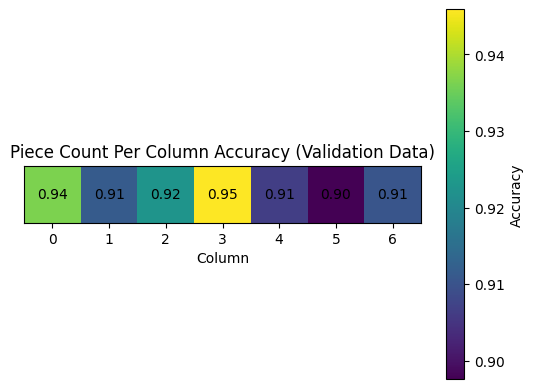

In [85]:
plot_heatmap(val_acc_col, w=7, h=1, title=f'Piece Count Per Column Accuracy (Validation Data)', xlabel='Column', ylabel='', disable_yticks=True)

Per row

In [86]:
train_acc_row = eval_probe(row_probe, row_train_loader, dim=train_Y_row.shape[-1])
train_acc_row

tensor([0.9110, 0.7812, 0.7772, 0.7800, 0.7731, 0.8313], device='cuda:0')

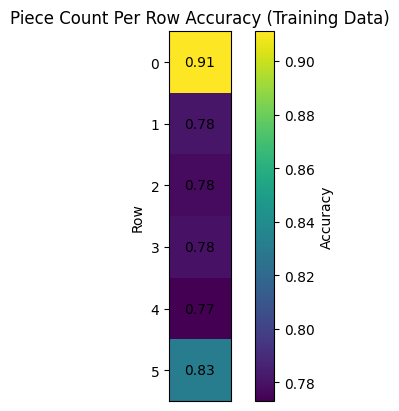

In [87]:
plot_heatmap(train_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Training Data)', xlabel='', ylabel='Row', disable_xticks=True)

In [88]:
row_val_loader = get_data_loader(val_X, val_Y_row)
val_acc_row = eval_probe(row_probe, row_val_loader, val_Y_row.shape[-1])
val_acc_row

tensor([0.8955, 0.7459, 0.7347, 0.7459, 0.7454, 0.8080], device='cuda:0')

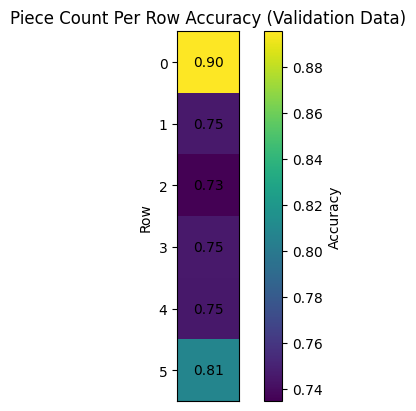

In [89]:
plot_heatmap(val_acc_row, w=1, h=6, title=f'Piece Count Per Row Accuracy (Validation Data)', xlabel='', ylabel='Row', disable_xticks=True)